# Spectral Analysis

We will demonstrate how to use Python to calculate power spectrum as documented in [NCL website](https://www.ncl.ucar.edu/Applications/spec.shtml). The code is generated by Google Gemini.

First, build the pre-defined functions as follows:

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import chi2

def specx_anal(data, d, sm, pct):
    """
    Python version of the NCL specx_anal function.
    Computes a smoothed one-dimensional power spectrum.
    
    Parameters:
    - data: Input one-dimensional time series (numpy array)
    - d: Detrend option (0: subtract mean, 1: linear detrend)
    - sm: Smoothing window size (odd number)
    - pct: Tapering percentage at both ends of the data
    
    Returns:
    - spec_info: A dictionary containing the spectral analysis results
    """
    n = len(data)
    
    # Linear detrend
    detrend_type = 'constant' if d == 0 else 'linear'
    
    # Tapering 
    window = signal.windows.tukey(n, alpha=2*pct)
    
    # Calculate Periodogram
    # fs=1: sampling frequency is once per time unit (SOI for example, once per month.)
    # scaling='density' obtains Power Spectral Density (PSD)
    # This step integrates windowing, detrending, FFT, and computing the one-sided spectrum
    freqs, pxx_raw = signal.periodogram(
        data, fs=1, window=window, detrend=detrend_type, scaling='density'
    )

    # Smooth the spectrum: use convolution for moving average
    smoother = np.ones(sm) / sm
    pxx_smooth = np.convolve(pxx_raw, smoother, mode='same')

    # Calculate Degrees of Freedom and bandwidth. Please refer to NCL documentation.
    dof = 2 * sm
    bw = dof / n  # 假設 dt=1
    
    spec_info = {
        'spcx': pxx_smooth,
        'frq': freqs,
        'dof': dof,
        'bw': bw
    }
    return spec_info

def specx_ci(original_data, spec_info, clevel_lower, clevel_upper):
    """
    Python version of the NCL specx_ci function.
    Computes confidence intervals based on red noise (AR1 process).
    
    Returns:
    - splt: A (4, n_freqs) array containing:
            [0]: Smoothed data spectrum
            [1]: Theoretical red noise spectrum
            [2]: Lower bound of the red noise confidence interval
            [3]: Upper bound of the red noise confidence interval
    """
    # Extract required variables from spec_info dictionary
    spcx = spec_info['spcx']
    freqs = spec_info['frq']
    dof = spec_info['dof']
    
    n_freqs = len(freqs)

    # Use original data to calculate lag-1 autocorrelation coefficient (r1)
    mean_data = original_data.mean()
    anom_data = original_data - mean_data
    r1 = np.corrcoef(anom_data[:-1], anom_data[1:])[0, 1]

    # Calculate theoretical red noise spectrum using the formula from Gilman et al. (1963)
    red_noise_spec = (1 - r1**2) / (1 - 2 * r1 * np.cos(2 * np.pi * freqs) + r1**2)

    # Normalize the total variance of the red noise spectrum to match the data spectrum
    red_noise_spec_normalized = red_noise_spec * (np.sum(spcx) / np.sum(red_noise_spec))

    # Calculate confidence intervals based on Chi-squared distribution
    chi2_lower = chi2.ppf(clevel_lower, dof)
    chi2_upper = chi2.ppf(clevel_upper, dof)
    
    lower_bound = red_noise_spec_normalized * (chi2_lower / dof)
    upper_bound = red_noise_spec_normalized * (chi2_upper / dof)

    # Return results
    splt = np.vstack([spcx, red_noise_spec_normalized, lower_bound, upper_bound])
    
    return splt

Using the SOI (Southern Oscillation Index) as an example, we will demonstrate the power spectrum calculated by the above functions. 

In [ ]:
ds = xr.open_dataset("./data/SOI_Darwin.nc")
soi_data = ds['DSOI'].values

# Setting parameters
d = 0      # Detrend option: 0=>remove mean
sm = 21    # Smoothing window: odd number at least 3
pct = 0.10 # Tapering percentage

# Compute spectrum
sdof = specx_anal(soi_data, d, sm, pct)

# Calculate confidence intervals (5% and 95%)
splt = specx_ci(soi_data,sdof, 0.05, 0.95)

Plotting

Lag-1 autocorrelation (r1): 0.5348


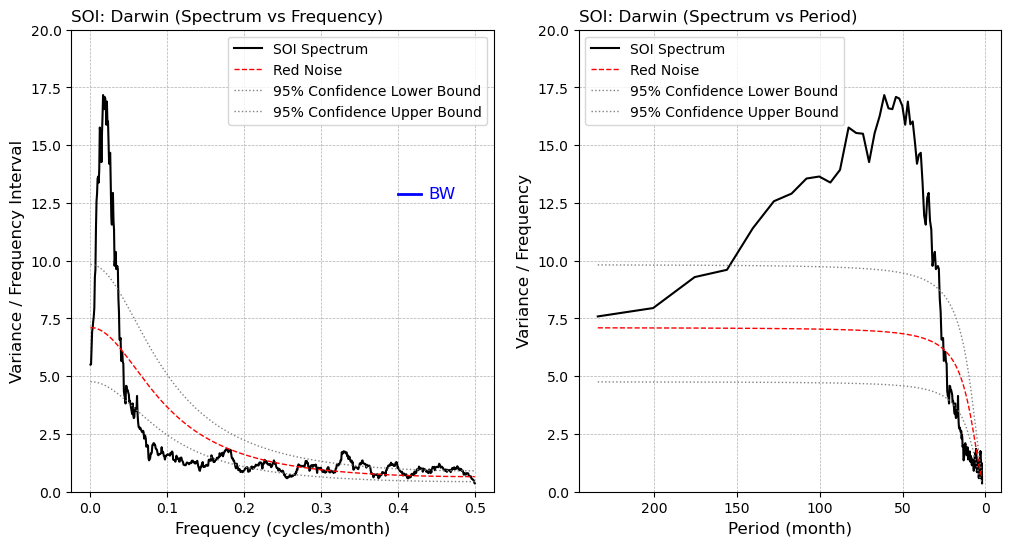

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12, 6))
ax=axes.flatten()

# (a) x-axis: frequency
ax[0].plot(sdof['frq'], splt[0,:], label='SOI Spectrum', color='black', lw=1.5)
ax[0].plot(sdof['frq'], splt[1,:], label='Red Noise', color='red', lw=1.0, linestyle='--')
ax[0].plot(sdof['frq'], splt[2,:], label='95% Confidence Lower Bound', color='gray', lw=1.0, linestyle=':')
ax[0].plot(sdof['frq'], splt[3,:], label='95% Confidence Upper Bound', color='gray', lw=1.0, linestyle=':')

ax[0].set_title("SOI: Darwin (Spectrum vs Frequency)", loc='left')
ax[0].set_xlabel("Frequency (cycles/month)", fontsize=12)
ax[0].set_ylabel("Variance / Frequency Interval", fontsize=12)
ax[0].set_ylim(0.0, 20.0) 
ax[0].grid(True, which="major", ls="--", linewidth=0.5)
ax[0].legend()

# Plot bandwidth (BW)
bw_x = [0.40, 0.40 + sdof['bw']]
bw_y_val = 0.75 * np.max(sdof['spcx'])
bw_y = [bw_y_val, bw_y_val]
ax[0].plot(bw_x, bw_y, color='blue', lw=2)
ax[0].text(0.41 + sdof['bw'], bw_y_val, "BW", color='blue', va='center', ha='left', fontsize=12)

# (b) x-axis: period
# Convert frequency to period
freqs_nonzero = sdof['frq'][1:]
splt_nonzero = splt[:, 1:]
period = 1 / freqs_nonzero

ip = period <= 240 # Only plot the part where period is less than or equal to 240 months

ax[1].plot(period[ip], splt_nonzero[0, ip], label='SOI Spectrum', color='black', lw=1.5)
ax[1].plot(period[ip], splt_nonzero[1, ip], label='Red Noise', color='red', lw=1.0, linestyle='--')
ax[1].plot(period[ip], splt_nonzero[2, ip], label='95% Confidence Lower Bound', color='gray', lw=1.0, linestyle=':')
ax[1].plot(period[ip], splt_nonzero[3, ip], label='95% Confidence Upper Bound', color='gray', lw=1.0, linestyle=':')

ax[1].set_title("SOI: Darwin (Spectrum vs Period)", loc='left')
ax[1].set_xlabel("Period (month)", fontsize=12)
ax[1].set_ylabel("Variance / Frequency", fontsize=12)
ax[1].set_ylim(0.0, 20.0)
ax[1].grid(True, which="major", ls="--", linewidth=0.5)
ax[1].legend()

ax[1].invert_xaxis()

print(f"Lag-1 autocorrelation (r1): {np.corrcoef(soi_data[:-1], soi_data[1:])[0, 1]:.4f}")